# Observed Change <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


## Mapping conversions and modifications of land cover

**Land Cover** is the physical and biological cover of the land surface and includes vegetation (managed or semi-natural), water and bare surfaces.  The land cover maps generated through Living Land Management use the legends of the United Nation's Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS).


The notebooks take you through the process of accessing the FAO LCCS layer at Level 3 (Basic; 6 classes) and Level 4 (over 100 classes). 

1. Loading and displaying DEA land cover classifications (basic and detailed) and contributing environmental descriptors for an area of interest.

3. Determing areas of land cover conversions (losses and gains) based on time-series comparison of the land cover maps between two years.
2. Determining areas of no change in the FAO LCCS Level 3 classes where there is potential for a modification to occur. 
3. Comparing the lifeform category of the FAO LCCS Level 3 
4. Determining a pressure (in this case, bushfires) from Landsat sensor data.
5. Combining the impacts and pressures to generate a classification according to the notation 'impact (pressure)

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

Transitions between any two Level 3 land cover types (off-diagonals in a transition matrix) correspond to a change in extent in both the original class at the time of the first observation (T1) and the replacement class in the second observation (T2) (i.e., a land cover **conversion**). More detailed descriptions of the land cover class prior to and following the change can be provided by referencing the categorical and continuous environmental descriptors used in the construction of the FAO LCCS classes at T1 and T2 respectively as well as AEDs. 


## Description 

For a selected area of interest, the notebook compares land cover data for any two years and generates maps of conversions (changes in extent) or modifications (no changes in extent but a change in type (e.g. lifeform) or condition of land covers).   

The notebooks take you through the process of:

1. Identifying an area interactively using a rectangle or polygon drawn freehand. 
2. Displaying the Level 3 land cover maps and environmental descriptors of lifeform, canopy cover, water persistence and water seasonality.  

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

## Change methods

## Background on data layers

This notebooks considers different approaches for quantifying change between above ground biomass generated for 2010 and 2017-2020 (annually) through the ESA CCI Biomass project.

## Description 

This notebook will demonstrate how to create change maps based on both impact and pressures, taken from Earth observation data or from external data layers.  

For demonstration, the capabiliy of the Digital Earth Australia (DEA) processing witin the framework of the Open Data Cube (ODC) is used.  Through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover, land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retreived or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  The spatial resolution of the mapping is 25 m 
(see DEA Land Cover) at https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)


The notebooks take you through the process of accessing the FAO LCCS layer at Level 3 (Basic; 6 classes) and Level 4 (over 100 classes). 

1. Loading land cover classifications (basic and detailed) for an area of interest.
2. Plotting a change map using Level 3 data. 
3. Plotting a change map (representing impacts) based on evidence gathered from Level 4 data.
4. Determining a pressure (in this case, bushfires) from Landsat sensor data.
5. Combining the impacts and pressures to generate a classification according to the notation 'impact (pressure)

This notebook requires a basic understanding of the DEA Land Cover data set. 
If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
import xarray as xr
import odc.geo.xr
#import rasterio
import geopandas as gpd # Added from WDC

from odc.algo import xr_reproject # From https://docs.dea.ga.gov.au/notebooks/How_to_guides/Reprojecting_data.html

import sys, os
sys.path.insert(1, os.path.abspath('../Tools'))
from dea_tools.plotting import rgb, display_map
from dea_tools.datahandling import wofs_fuser  # Added from DEA plotting
from dea_tools.plotting import rgb, plot_wo  # Added from DEA plotting
from matplotlib import colors as mcolours
from dea_tools.landcover import plot_land_cover, lc_colourmap, make_colorbar
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils import masking # Added from DEA plotting
from datacube.utils.masking import mask_invalid_data
#from datacube.utils import cog  # Temporarily disabled
from datacube.utils.cog import write_cog
# from display_tools import map_geom, rgb # from WDC - not accessing
from ipyleaflet import GeoData # Added from WDC 
from time import time as time # Added from burn notebook
import datetime as dt # Added from burn notebook
from odc.geo.geom import Geometry
from dea_tools.plotting import rgb

from matplotlib.colors import ListedColormap # Added from WDC
import matplotlib.colors as colors # Added from WDC
from matplotlib import colormaps
import matplotlib.pyplot as plt # Added from WDC
from matplotlib.patches import Patch # Added from WDC

from time import time as time # Added from WDC
import warnings # Added from WDC
warnings.filterwarnings("ignore") # Added from WDC

sys.path.append("../Working")
from landcover import plot_land_cover, lc_colourmap, make_colorbar #added from DEA

#For DEA burn mapping
from datetime import datetime
from datetime import timedelta

from dea_tools.datahandling import load_ard
from dea_tools.plotting import rgb, display_map
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37257,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:43161,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/45171/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:40839,


## Getting started

To run this analysis, run all the cells in the notebook starting with the 'Load packages and connect to the datacube' cell.

### Load packages

Load key Python packages and supporting functions for the analysis, then connect to the datacube. 

### Connect to the datacube
Connect to the datacube so we can access DEA data. 

In [2]:
dc = datacube.Datacube(app="Land_cover_change_mapping")

## Select and view your study area

**If running the notebook for the first time,** keep the default settings below.
This will demonstrate how the change mapping functionality works and provide meaningful results.
The following example loads land cover data over Mount Ney in Western Australia, a region which has experienced extensive bushfires and variations in water inundation over the 34 years of observation.  

**NOTE:  You can change the area of interest and also the time range in subsequent user-selected runs of the notebook.

In [35]:
# Mount Ney, Western Australia (120.0,125.0,-35.0,-30.0 [EPSG:4326])
#lat, lon = (-32.5, 122.5)
#lat_buffer = 0.1
#lon_buffer = 0.1

# Leichhardt River
#lat, lon = (-17.6401, 139.8175)
#lat_buffer = 0.1
#lon_buffer = 0.1

# Weipa_all
#lat, lon = (-12.55, 141.90)
#lat_buffer = 0.17
#lon_buffer = 0.20

# Weipa-south
#lat, lon = (-12.67, 141.93)
#lat_buffer = 0.09
#lon_buffer = 0.13

# Hinchinbrook
#lat, lon = (-18.36, 146.20)
#lat_buffer = 0.12
#lon_buffer = 0.12

# Moreton Island 
#lat, lon = (-27.550, 153.46)
#lat_buffer = 0.15
#lon_buffer = 0.12

# Fitzroy
#lat, lon = (-23.5134, 150.8100)
lat, lon = (-23.5663, 150.7123) # Casuarina creek
lat_buffer = 0.025
lon_buffer = 0.03

#lat, lon = (-32.7181, 122.1832)
#lat_buffer= 0.15
#lon_buffer = 0.15

# Combine central coordinates with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)



In [36]:
# Get colour map for image
# cmap, norm = lc_colourmap('level3_change_colour_scheme') - PREVIOUS USING 
cmap, norm = lc_colourmap('level3_change_colour_scheme')

In [37]:
display_map(x=lon_range, y=lat_range)

# Define dates and/or period of interest


#### Load and reproject CCI Biomass data

## 3.1  Observed change
The observed change considers conversions (i.e., changes in extent of the Level 3 classes) and modification (i.e., the level 3 class remains the same but there are changes in categorical (e.g., lifeform) or continuous (e.g., water hydroperiod) environmental descriptors.  

#### Numerical key for changes in overarching environmental descriptors
01: CTV greening 				111111 - cover  
02: CTV browning 				111111 - cover  
03: CAV wetting  				123123 - moisture  
04: CAV drying   				123123 - moisture  
05: NTV extent loss 			112 to ALL  
06: NTV extent gain				ALL to 112  
07: NTV herbaceous increase		112112 – cover (non-woody)  
08: NTV herbaceous decrease		112112 – cover (non-woody)  
09: NTV woody increase			112112 – cover and woody fraction  
10: NTV woody decrease			112112 – cover and woody fraction  
11: NAV extent gain				124 to ALL 
12: NAV extent loss				ALL to 124  
13: NAV herbaceous vegetation increase	124124	- cover (non-woody)  
14: NAV herbaceous vegetation decreases	124124	- cover (non-woody)  
15: NAV woody vegetation increase		124124	- cover and woody fraction  
16: NAV woody vegetation decreases		124124	- cover and woody fraction  
17: AS extent gain				ALL to 215  
18: AS extent loss				215 to ALL  
19: NWAW extent gain 			ALL to 220  
20: NWAW extent loss			220 to ALL  
21: NWAW persistence increase	220220 – water persistence  
22: NWAW Persistence decrease	220220 – water persistence
23: Conversion of NTV to NAV
24: Conversion of NAV to NTV
25: Conversion of CTV to CAV
26: Conversion of CAV to CTV
27: NTV loss to urban
28: NAV loss to urban

Note that 27 and 28 avoids the duplication of 112 to 215 in 12 and also in 17.

### Plot the land cover over the time-series (level 3 and lifeform)

## Load and view the Environmental Descriptors (EDs)
The following cell will load what are termed the Environmental Descriptors (EDs) used to construct the Basic (Level 3) and subsequently the Detailed (Level 4) land cover maps for the `lat_range`, `lon_range` and `time_range` defined for your area of interest.

You can view each of these layers using the  `plot_land_cover()` function.

** Note:  You can run one, several or all of these to view the appropriate product.

In [38]:
# Set the range of dates for the analysis
time_range = ("2009", "2020")

In [39]:
# Create the 'query' dictionary object, which contains the longitudes, latitudes and time defined above
query = {
    "y": lat_range,
    "x": lon_range,
    "time": time_range,
}

# Load DEA Land Cover data from the datacube
lc = dc.load(
    product="ga_ls_landcover_class_cyear_2",
    output_crs="EPSG:3577",
    measurements=[
        "level3",
        "lifeform",
        "vegetation_cover",
        "water_seasonality",
        "water_state",
        "intertidal",
        "water_persistence",
        "bare_gradation",
        "full_classification",
    ],
    resolution=(-25, 25),
    **query
)

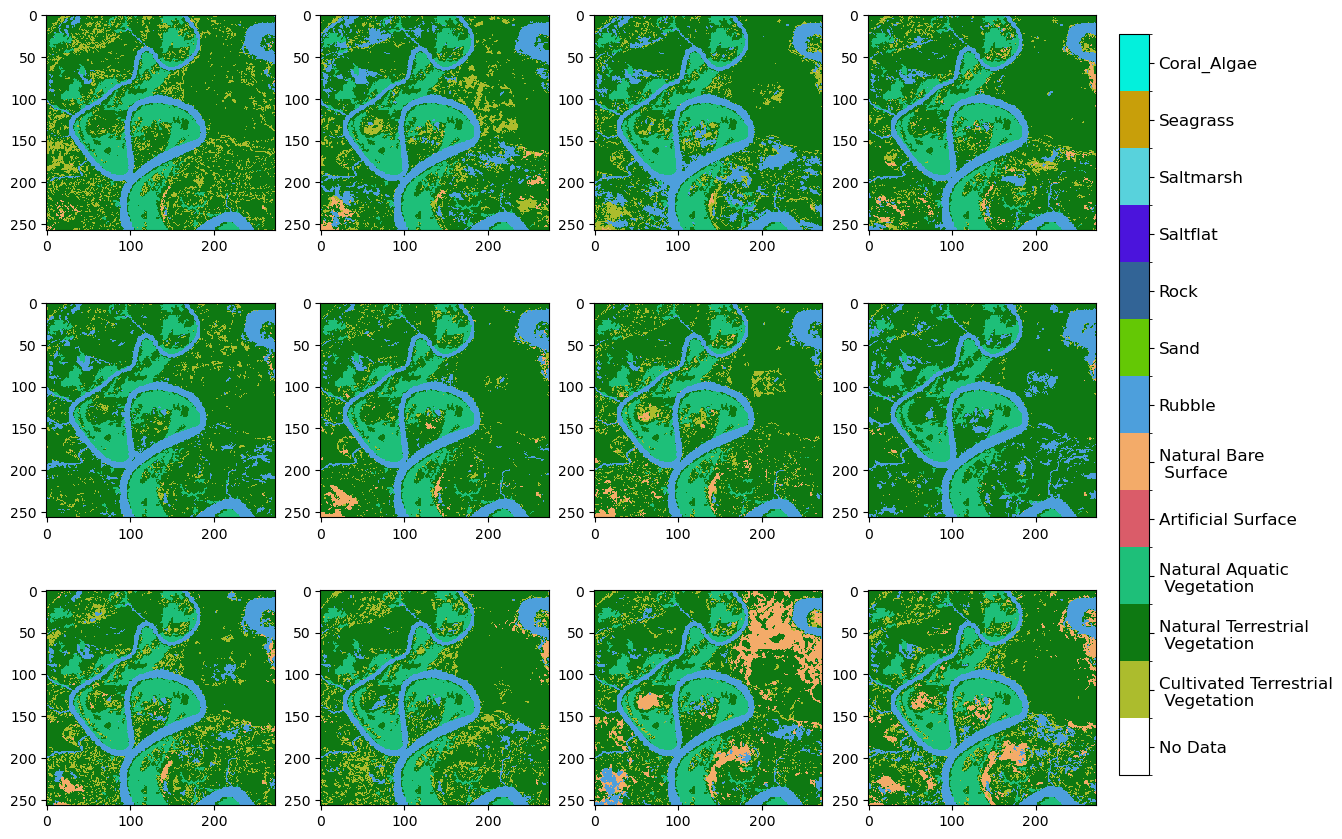

In [40]:
plot_land_cover(lc.level3)

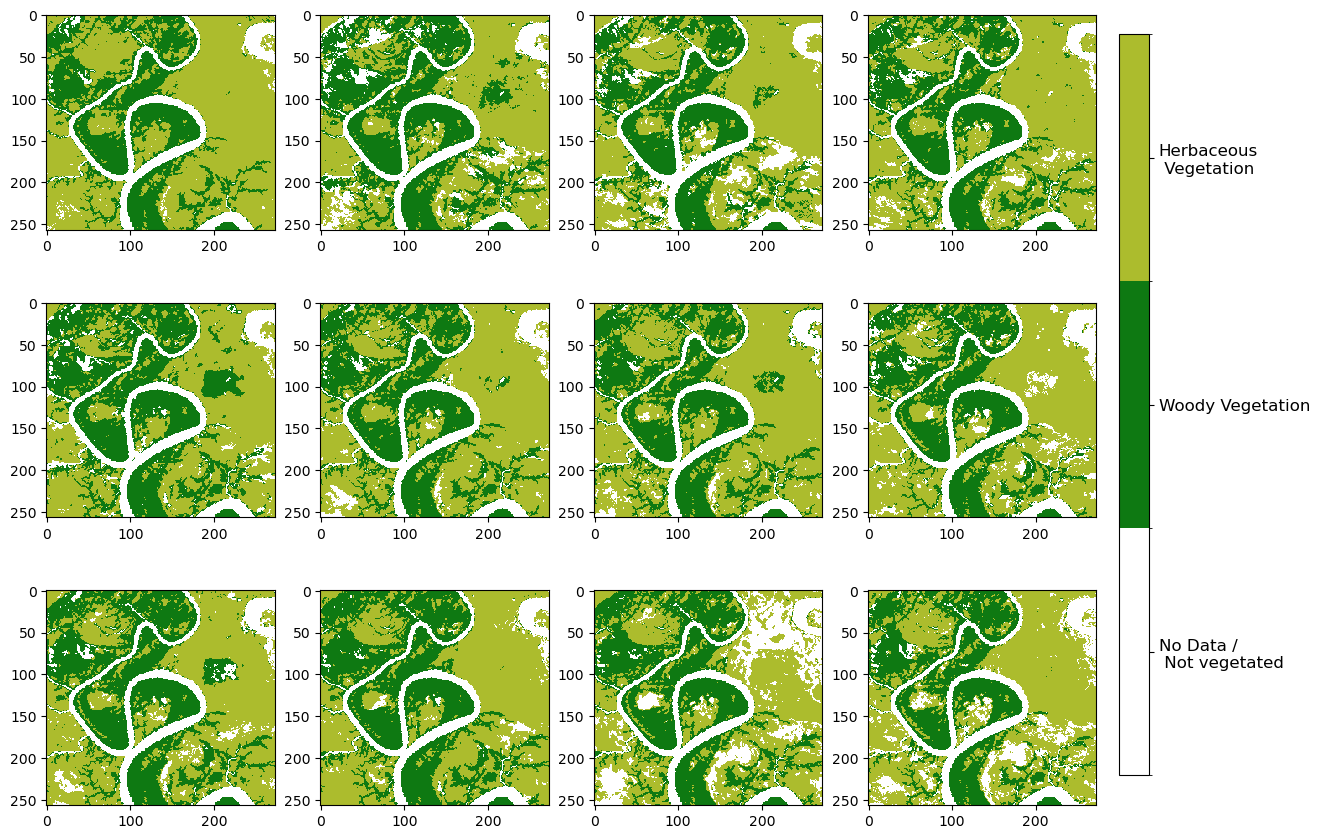

In [41]:
plot_land_cover(lc.lifeform)

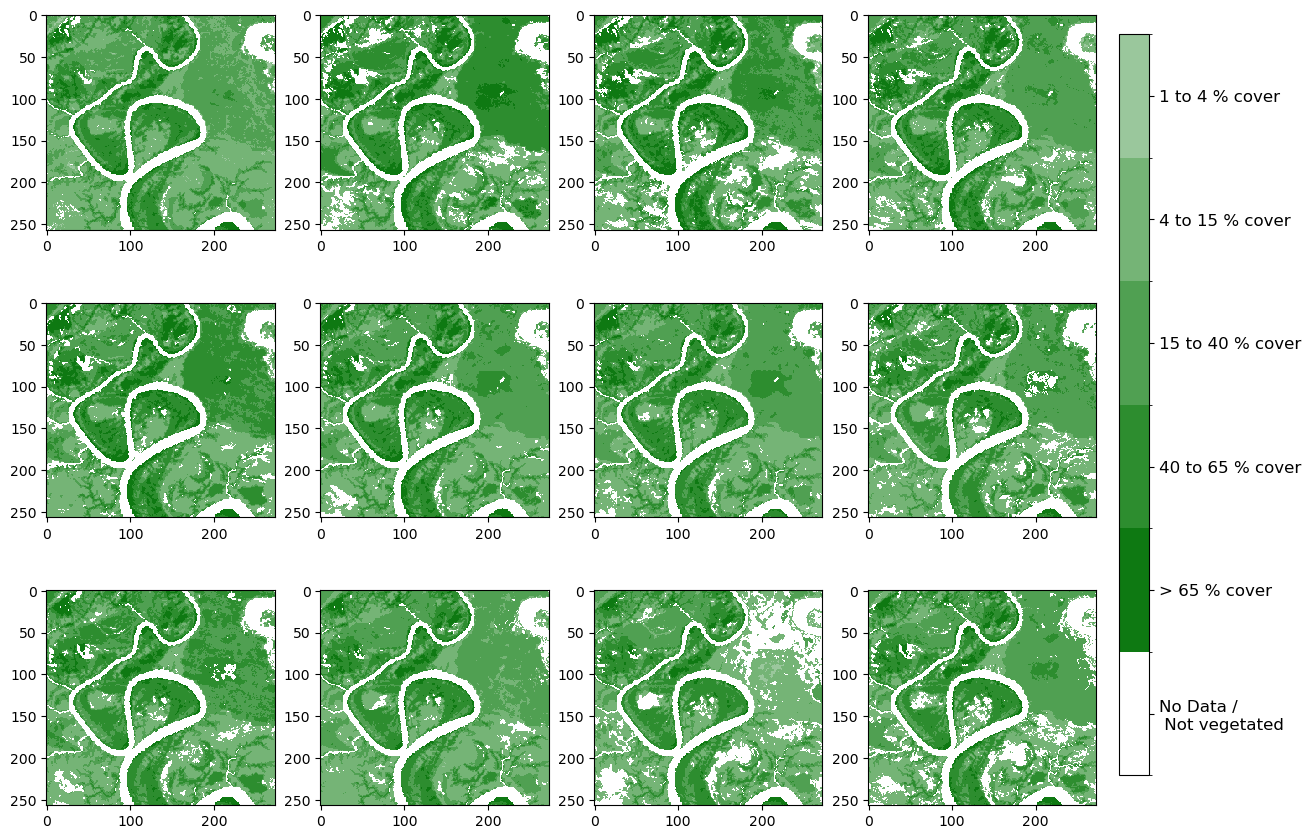

In [42]:
plot_land_cover(lc.vegetation_cover)

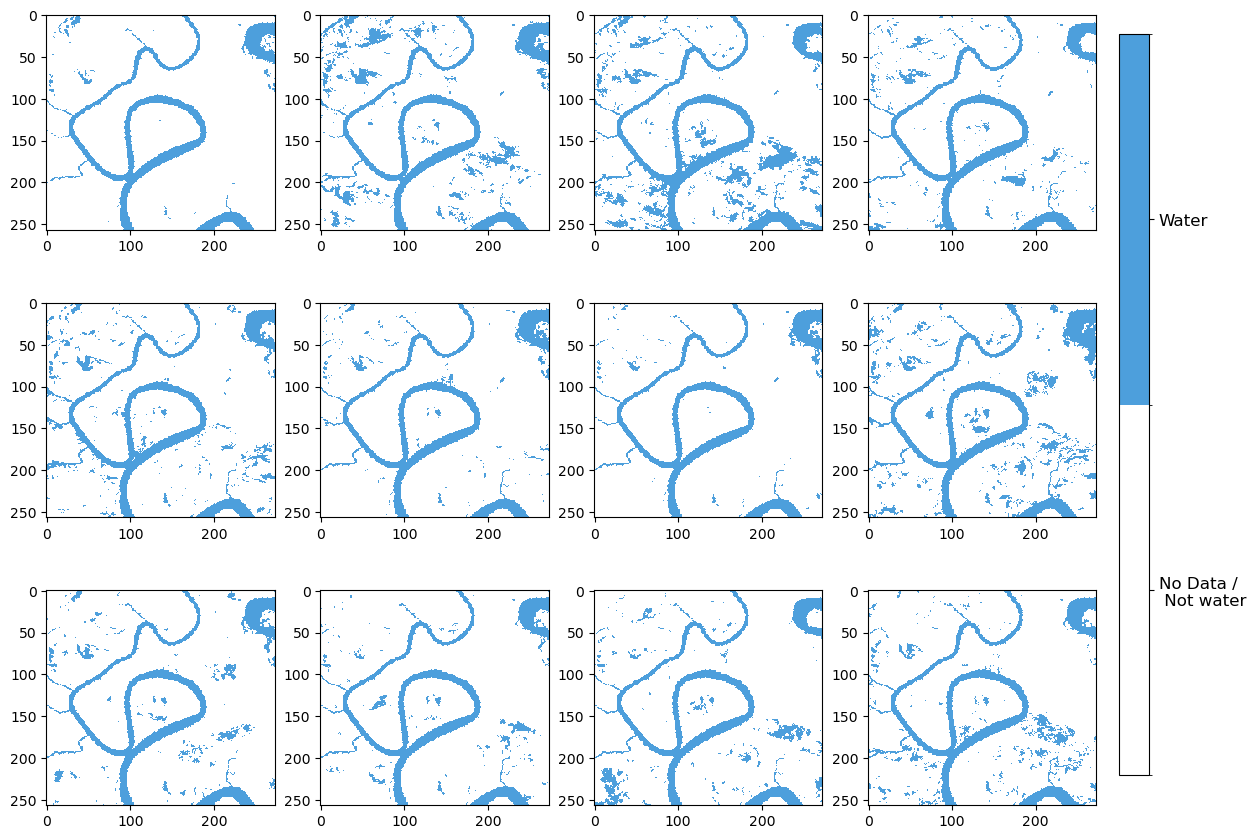

In [43]:
plot_land_cover(lc.water_state)

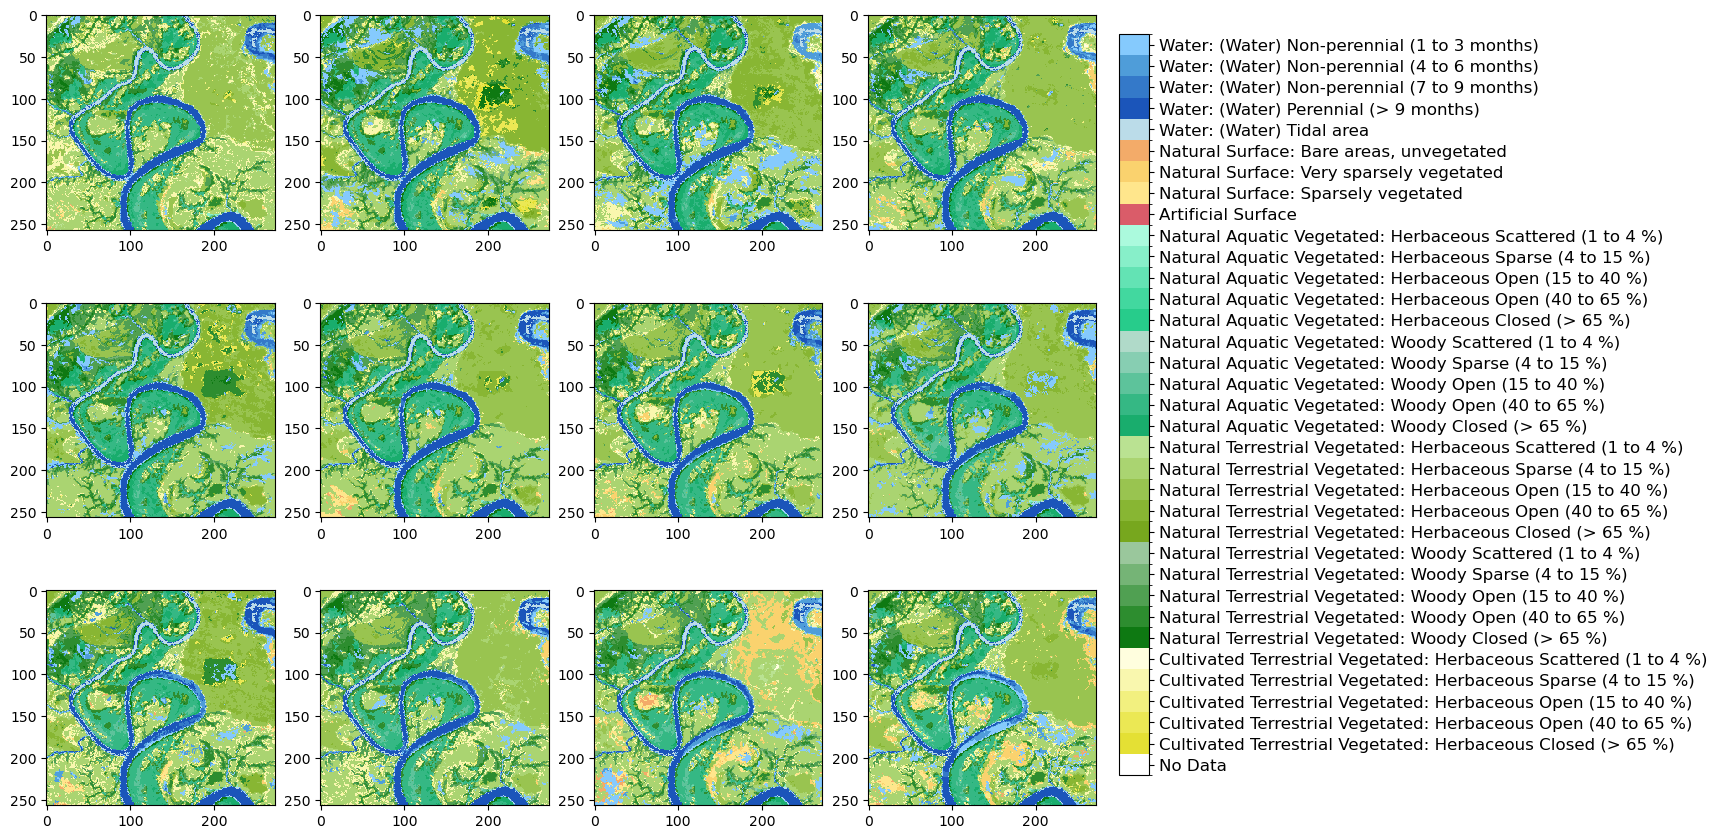

In [44]:
plot_land_cover(lc.full_classification)

In [45]:
lc.geobox

GeoBox(273, 257, Affine(25.0, 0.0, 1880775.0,
       0.0, -25.0, -2677050.0), PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]])

### Level 3 change maps 

A first step towards developing a globally relevant and standardized taxonomy and framework for consistently describing land cover change was to establish the transition matrix between observed broad land cover classes (i.e., OEDs).  This stage was developed and is illustrated using the FAO LCCS given the dichotomous and then hierarchical modular structure of this taxonomy.  Between-class transitions and within-class changes can be identified by comparing these OEDs (i.e., the FAO LCCS Level 3 classes; 8 in total) between any two time-separated periods (i.e., T1 and T2), leading to 64 potential change categories; 56 on the off-diagonals and 8 on the on-diagonals.  

** Note:  There are 6 classes in the case of Australia as there are limited cultivated aquatic landscapes, and artificial and natural water are merged.

In the following steps, you will compare the earliest and latest Level 3 layers in selected time-series.

#### Select the start and end dates for comparisons of enviromental descriptors 
(e.g., Level 3, lifeform, vegetation cover, water state and level 4 (full classification))

#### ALL LEVEL 3 CHANGES

### NO CHANGE

#### Areas of no change from 2010 [0] to 2020 [-1 or 4]

In [46]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = False

# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
    
level_3 = lc.level3[0].drop_vars("time") 

# Create a new Xarray.DataArray
obs_change_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [47]:
obs_change_l3 = obs_change_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_change_l3_2010_2020

#### Areas of no change from 2017 [1] to 2018 [2]

In [48]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)
ignore_no_change = False # Mark if you want to ignore no change
# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [49]:
# Create a new Xarray.DataArray
obs_change_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [50]:
obs_change_l3["l3_2017_2018"] = obs_change_l3_2017_2018
del obs_change_l3_2017_2018

#### Areas of no change from 2018 [2] to 2019 [3]

In [51]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [52]:
# Create a new Xarray.DataArray
obs_change_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [53]:
obs_change_l3["l3_2018_2019"] = obs_change_l3_2018_2019
del obs_change_l3_2018_2019

#### Areas of no change from 2019 [3] to 2020 [4 or -1]

In [54]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [55]:
# Create a new Xarray.DataArray
obs_change_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [56]:
obs_change_l3["l3_2019_2020"] = obs_change_l3_2019_2020
del obs_change_l3_2019_2020

#### Areas of no change from 2017 [1] to 2020 [4 or -1]

In [57]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [58]:
# Create a new Xarray.DataArray
obs_change_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [59]:
obs_change_l3["l3_2017_2020"] = obs_change_l3_2017_2020
del obs_change_l3_2017_2020

In [60]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_scheme')

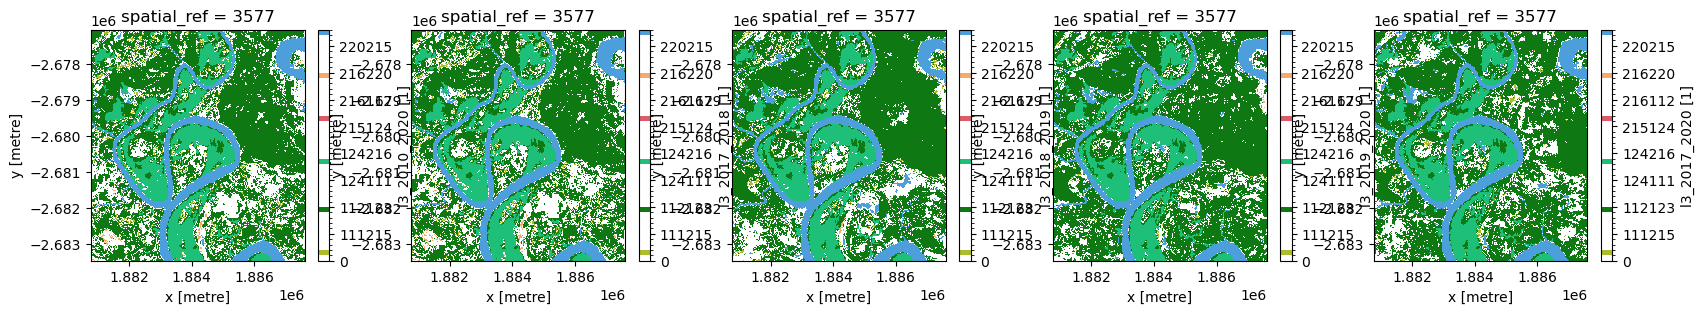

In [61]:
obs_change_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_change_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm)
obs_change_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) 
obs_change_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm)
obs_change_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm)
obs_change_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) 

In [67]:
# Save .png to folder
obs_change_l3_fig.savefig('./outputs/Level 3 no change.png')

In [132]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_change_l3["l3_2010_2020"],
          fname='./outputs/obs_change_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_change_l3_2010_2020.tif')

### GAINS

#### Change (gains) in Level 3 from 2010 [0] to 2020 [4 or -1]

In [68]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [69]:
level_3 = lc.level3[0].drop_vars("time")

In [70]:
# Create a new Xarray.DataArray
obs_gain_l3_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [71]:
obs_gain_l3 = obs_gain_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_gain_l3_2010_2020

#### Change (gains) from 2017 [1] to 2018 [2]

In [72]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)

# Mark if you want to ignore no change
ignore_no_change = True

In [73]:
# Mark if you want to ignore no change
ignore_no_change = True

In [74]:
# Combine classifications from start and end dates
change_vals = (start * 1000) + end

# Mask out values with no change by setting to 0 if this is requested
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)

In [75]:
level_3 = lc.level3[0].drop_vars("time")

In [76]:
# Create a new Xarray.DataArray
obs_gain_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [77]:
obs_gain_l3["l3_2017_2018"] = obs_gain_l3_2017_2018
del obs_gain_l3_2017_2018

#### Change (gains) from 2018 [2] to 2019 [3]

In [78]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [79]:
# Create a new Xarray.DataArray
obs_gain_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [80]:
obs_gain_l3["l3_2018_2019"] = obs_gain_l3_2018_2019
del obs_gain_l3_2018_2019

#### Change (gains)( from 2019 [3] to 2020 [4 or -1]

In [81]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [82]:
# Create a new Xarray.DataArray
obs_gain_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [83]:
obs_gain_l3["l3_2019_2020"] = obs_gain_l3_2019_2020
del obs_gain_l3_2019_2020

#### Change (gains) from 2017 [1] to 2020 [4 or -1]

In [84]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (start * 1000) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [85]:
# Create a new Xarray.DataArray
obs_gain_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [86]:
obs_gain_l3["l3_2017_2020"] = obs_gain_l3_2017_2020
del obs_gain_l3_2017_2020

### Plot Level 3 gains

In [87]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_gain')

2024-07-24 02:34:22,405 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


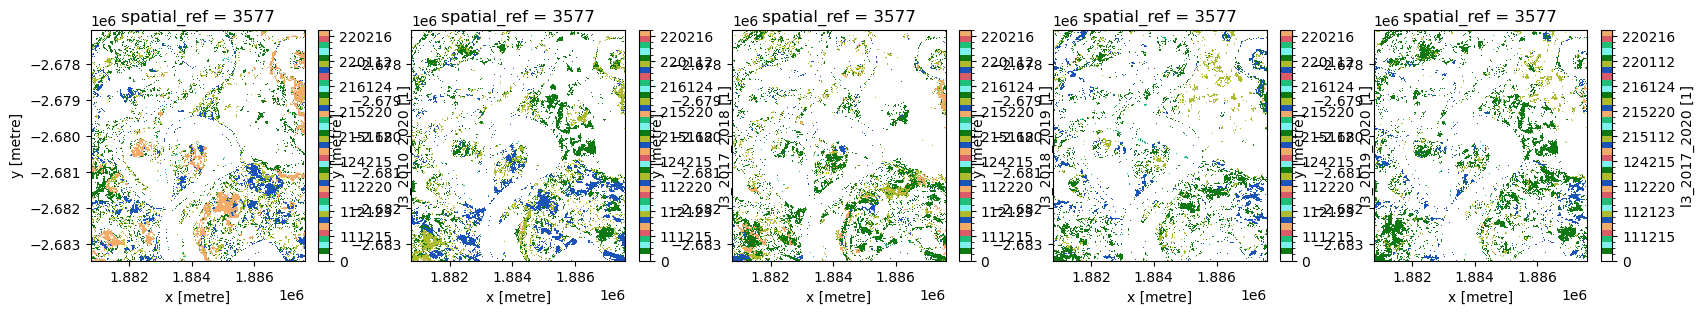

In [88]:
obs_gain_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_gain_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
obs_gain_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [89]:
# Save .png to folder
obs_gain_l3_fig.savefig('./outputs/Level 3 gains.png')

In [133]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_gain_l3["l3_2010_2020"],
          fname='./outputs/obs_gain_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_gain_l3_2010_2020.tif')

### LOSSES

#### Identify change (loss) in Level 3 from 2010 [0] to 2020 [-1 or 4]

In [91]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
# (Note changing to (end * 1000) + start
start = lc.level3[0].astype(np.int32)
end = lc.level3[-1].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
#level_3 = lc.level3[0].drop_vars("time")

In [92]:
# Create a new Xarray.DataArray
obs_loss_l3_2010_2020= xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed losses",
    attrs=level_3.attrs,
    fastpath=False,
)

In [93]:
obs_loss_l3 = obs_loss_l3_2010_2020.to_dataset(name="l3_2010_2020")
del obs_loss_l3_2010_2020

In [94]:
# Get colour map for image
#cmap, norm = lc_colourmap('level3_change_colour_scheme')
cmap, norm = lc_colourmap('level3_change_colour_loss')

In [95]:
#obs_loss_l3["l3_2017_2020"] = obs_loss_l3

In [96]:
#obs_loss_l3_fig, axs = plt.subplots(figsize=(20, 10), ncols=2)
#obs_loss_l3.l3_2017_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease

#### Change from 2017 [1] to 2018 [2]

In [97]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[2].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [98]:
# Create a new Xarray.DataArray
obs_loss_l3_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [99]:
obs_loss_l3["l3_2017_2018"] = obs_loss_l3_2017_2018
del obs_loss_l3_2017_2018

#### Change from 2018 [2] to 2019 [3]

In [100]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[2].astype(np.int32)
end = lc.level3[3].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [101]:
# Create a new Xarray.DataArray
obs_loss_l3_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [102]:
obs_loss_l3["l3_2018_2019"] = obs_loss_l3_2018_2019
del obs_loss_l3_2018_2019

#### Change from 2019 [3] to 2020 [4]

In [103]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[3].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [104]:
# Create a new Xarray.DataArray
obs_loss_l3_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

In [105]:
obs_loss_l3["l3_2019_2020"] = obs_loss_l3_2019_2020
del obs_loss_l3_2019_2020

#### Change from 2017 [1] to 2020 [4]

In [106]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.level3[1].astype(np.int32)
end = lc.level3[4].astype(np.int32)
ignore_no_change = True
change_vals = (end * 1000) + start
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
level_3 = lc.level3[0].drop_vars("time")

In [107]:
# Create a new Xarray.DataArray
obs_loss_l3_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=level_3.coords,
    dims=level_3.dims,
    name="observed change",
    attrs=level_3.attrs,
    fastpath=False,
)

#### Plot Level 3 losses

In [108]:
obs_loss_l3["l3_2017_2020"] = obs_loss_l3_2017_2020
del obs_loss_l3_2017_2020

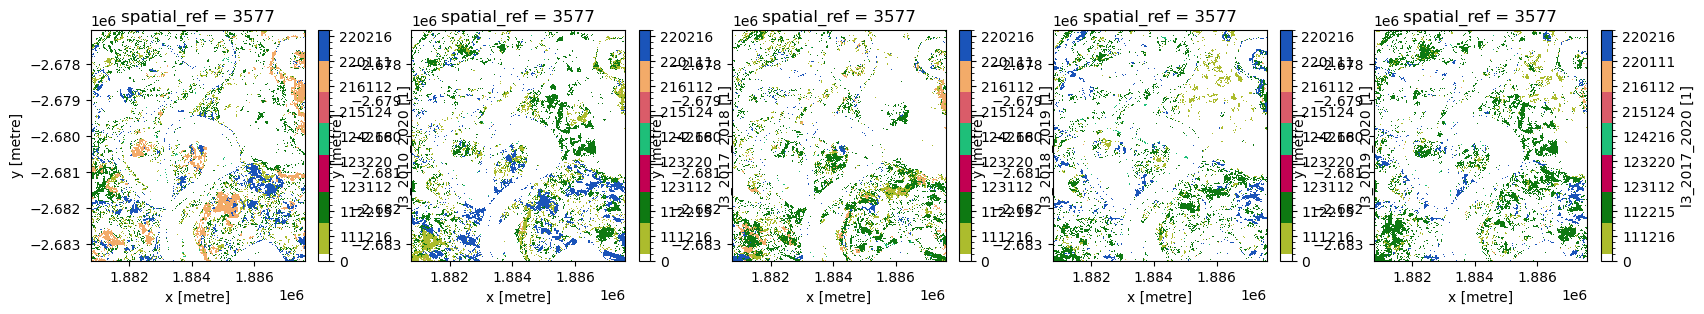

In [109]:
obs_loss_l3_fig, axs = plt.subplots(figsize=(20, 3), ncols=5)
obs_loss_l3.l3_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
obs_loss_l3.l3_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [110]:
# Save .png to folder
obs_loss_l3_fig.savefig('./outputs/Level 3 losses.png')

In [134]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_loss_l3["l3_2010_2020"],
          fname='./outputs/obs_loss_l3_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_loss_l3_2010_2020.tif')

## Lifeform change maps

#### Change in Lifeform from 2010 [0] to 2020 [4 or -1]

In [112]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[0].astype(np.int32)
end = lc.lifeform[-1].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[0].drop_vars("time")

In [113]:
# Create a new Xarray.DataArray
obs_change_lf_2010_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [114]:
obs_change_lf = obs_change_lf_2010_2020.to_dataset(name="lf_2010_2020")
del obs_change_lf_2010_2020

#### Change from 2017 [1] to 2018 [2]

In [115]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[1].astype(np.int32)
end = lc.lifeform[2].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[1].drop_vars("time")

In [116]:
# Create a new Xarray.DataArray
obs_change_lf_2017_2018 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [117]:
obs_change_lf["lf_2017_2018"] = obs_change_lf_2017_2018
del obs_change_lf_2017_2018

#### Change from 2018 [2] to 2019 [3]

In [118]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[2].astype(np.int32)
end = lc.lifeform[3].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[2].drop_vars("time")

In [119]:
# Create a new Xarray.DataArray
obs_change_lf_2018_2019 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [120]:
obs_change_lf["lf_2018_2019"] = obs_change_lf_2018_2019
del obs_change_lf_2018_2019

#### Change from 2019 [3] to 2020 [4]

In [121]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[3].astype(np.int32)
end = lc.lifeform[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[3].drop_vars("time")

In [122]:
# Create a new Xarray.DataArray
obs_change_lf_2019_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [123]:
obs_change_lf["lf_2019_2020"] = obs_change_lf_2019_2020
del obs_change_lf_2019_2020

#### Change from 2017 [1] to 2020 [4]

In [124]:
# Select start and end dates for comparison (change to int32 to ensure we can hold number of 6 digits)
start = lc.lifeform[1].astype(np.int32)
end = lc.lifeform[4].astype(np.int32)
ignore_no_change = False
change_vals = (start * 10) + end
if ignore_no_change:
    change_vals = np.where(start == end, 0, change_vals)
lifeform = lc.lifeform[4].drop_vars("time")

In [125]:
# Create a new Xarray.DataArray
obs_change_lf_2017_2020 = xr.DataArray(
    data=change_vals,
    coords=lifeform.coords,
    dims=lifeform.dims,
    name="observed change",
    attrs=lifeform.attrs,
    fastpath=False,
)

In [126]:
obs_change_lf["lf_2017_2020"] = obs_change_lf_2017_2020
del obs_change_lf_2017_2020

#### Plot lifeform change

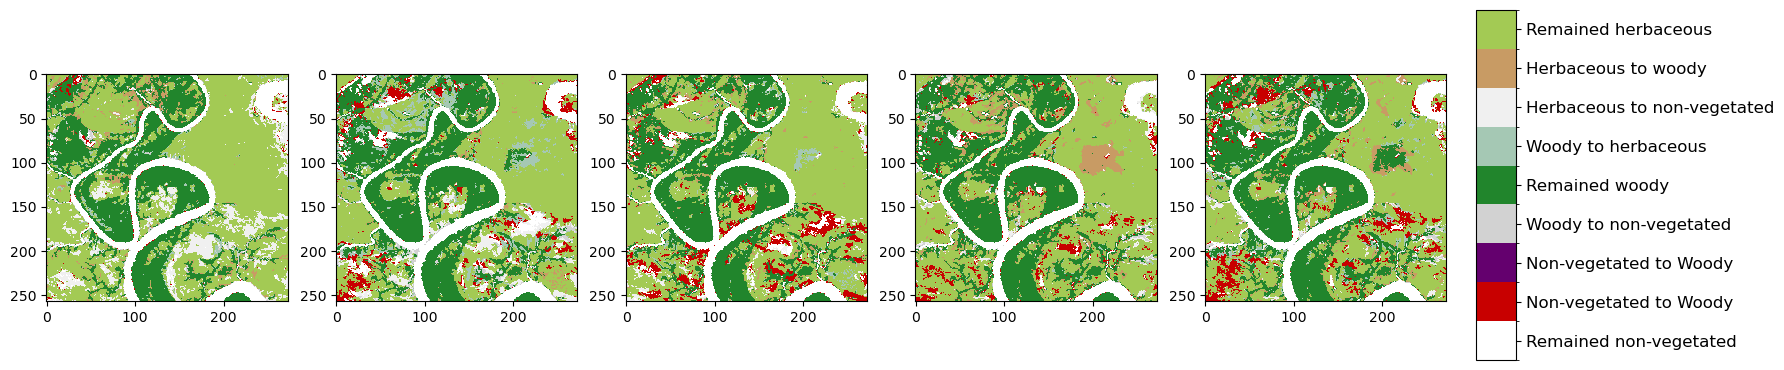

In [127]:
# Create figure with subplot and set size in inches
fig, axs = plt.subplots(figsize=(20, 5), ncols=5)
# fig.set_size_inches(7, 7)

make_colorbar(fig, axs[2], measurement='lfchange_colour_scheme')
cmap, norm = lc_colourmap('lfchange_colour_scheme')

# Plot change data
axs[0].imshow(obs_change_lf.lf_2010_2020, cmap=cmap, norm=norm, interpolation="nearest")
axs[1].imshow(obs_change_lf.lf_2017_2018, cmap=cmap, norm=norm, interpolation="nearest")
axs[2].imshow(obs_change_lf.lf_2018_2019, cmap=cmap, norm=norm, interpolation="nearest")
axs[3].imshow(obs_change_lf.lf_2019_2020, cmap=cmap, norm=norm, interpolation="nearest")
axs[4].imshow(obs_change_lf.lf_2017_2020, cmap=cmap, norm=norm, interpolation="nearest")

#####  Another way of plotting (but slower)
#obs_change_lf_fig, axs = plt.subplots(figsize=(30, 4), ncols=5)
#obs_change_lf.lf_2010_2020.plot(ax=axs[0], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2017_2018.plot(ax=axs[1], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2018_2019.plot(ax=axs[2], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2019_2020.plot(ax=axs[3], cmap=cmap, norm=norm) # Significant decrease
#obs_change_lf.lf_2017_2020.plot(ax=axs[4], cmap=cmap, norm=norm) # Significant decrease

In [128]:
# Save .png to folder
fig.savefig('./outputs/lifeform change.png')
del fig

In [135]:
#This method uses the datacube.utils.cog function write_cog (where COG stands for Cloud Optimised GeoTIFF) 
#to export a simple single-band, single time-slice GeoTIFF file. A few important caveats should be noted when using this function:
#It requires an xarray.DataArray; supplying an xarray.Dataset will return an error. 

# Write GeoTIFF to a location
write_cog(geo_im=obs_change_lf["lf_2010_2020"],
          fname='./outputs/obs_change_lf_2010_2020.tif',
          overwrite=True)

PosixPath('outputs/obs_change_lf_2010_2020.tif')

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** February 2022

**Compatible datacube version:** 

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)